In [8]:
from matplotlib import pyplot as plt
import sys
import math
import pandas as pd
import numpy as np
%matplotlib inline



File format for this bed file is:  
Chrom	start	stop	probeID  	A 	T 	G 	C

The things I want to collect include:
1. Number of probes with a homozygous variant
2. Number of probes with a heterozygous variant
3. Allele ratios for each of the probes
4. Total coverage of each of the probes

Additionally, with these probes, there are both Copy-number and SNP-based probes.  The copy number probes are C-[A-9], and the SNP probes are S-[A-9].

Since I have the probe IDs, I can parse these out separately to see how many of the polymorphic SNP probes are actually heterozygous.


In [9]:
def GetPositionalCoverages(infile):
    Coverages = {}
    Positions = {}
    Homozygous_Count = 0
    Heterozygous_Count = 0
    
    SNPprobes = 0
    Copyprobes = 0
    
    for line in infile:
        if line[0]=='#':
            continue
        #print line
        cols = line.strip('\n').split('\t')
        chromosome = cols[0]
        position = int(cols[1])
        #Positions.append(position)
        probeID = cols[3]
        #Probe IDs are broken down into S- and C-, described above
        # Here I'll take these probe IDs and count the amount of each.
    
        Acount = int(cols[4])
        Tcount = int(cols[5])
        Gcount = int(cols[6])
        Ccount = int(cols[7])

        # Calculate the total coverages
        CoverageTotal = sum([Acount,Tcount,Gcount,Ccount])

        #Calculate the allelic ratios
        MaxAllele1 = float(max([Acount,Tcount,Gcount,Ccount]))
        try:
            AllelicRatio = MaxAllele1/CoverageTotal
        except(ZeroDivisionError):
            AllelicRatio = 0        
        if Positions.has_key(chromosome):
            Positions[chromosome].append(position)
            Coverages[chromosome].append(CoverageTotal)            
        else:
            Positions[chromosome]=[position]
            Coverages[chromosome]=[CoverageTotal]
        
        if probeID[0]=='S':
            SNPprobes +=1
        elif probeID[0]=='C':
            Copyprobes +=1
        
        if (AllelicRatio <= .9) and probeID[0]=='S':
            Heterozygous_Count +=1
        elif (AllelicRatio >= .9) and probeID[0]=='S':
            Homozygous_Count +=1    
    
    print Coverages.keys()
    print Positions.keys()
    print "There are %d SNP probes in this set, of which %d are homozygous, and %d are heterozygous"%(SNPprobes,Homozygous_Count,Heterozygous_Count)
    return Positions,Coverages

In [10]:
def CoverageAssess(COVERAGES):
    for chrom in COVERAGES.keys():
        COV_AVG = sum(COVERAGES[chrom])/len(COVERAGES[chrom])
        print COV_AVG
        #plt.hist(Coverages,bins=25,range=[0, 100])    
    
#CoverageAssess(Coverages)    
        

In [11]:
def PlotCoverage(positions,coverages,sampleID,chromosome,start,stop,extra,YlimMin,YlimMax,Ylabel,MarkerSize,MarkerAlpha,Figname):
    fig = plt.figure(figsize=(15,5))
    axes = fig.add_subplot(111)
    
    #Define our region
    cnvlen = stop - start
    extraside = cnvlen * extra
    XlimMin= start - extraside
    XlimMax = stop + extraside
    
    # subset the coverages we want
    plotpositions = []
    plotcoverages = []
    for i in range(len(positions[chromosome])):
        if positions[chromosome][i] < XlimMin:
            continue
        elif (positions[chromosome][i] > XlimMin) and (positions[chromosome][i] < XlimMax):
            plotpositions.append(positions[chromosome][i])
            plotcoverages.append(coverages[chromosome][i])
        elif positions[chromosome][i] > XlimMin:
            break

    #print plotpositions
    #print plotcoverages
    
    axes.scatter(plotpositions,plotcoverages,c="blue",alpha=MarkerAlpha,s=MarkerSize,lw=0)
    axes.plot([start,stop],[95,95],color='k', linestyle='-', linewidth=2)

    axes.set_xlim(XlimMin,XlimMax)
    axes.set_ylim(YlimMin,YlimMax)
    axes.set_title(sampleID)
    axes.set_xlabel("Chromosomal Coordinate")
    axes.set_ylabel(Ylabel)
    #print(len(positions))
    plt.savefig("%s_%s_GenomicScatter.svg"%(Figname,Ylabel))
    plt.savefig("%s_%s_GenomicScatter.png"%(Figname,Ylabel))
    plt.show()

#PlotCoverage(Positions,Coverages,"T065-1","chr1",72760000,72820000,1,-0.5,100,"Coverage",25,1,"Testing T065-1 Good Del")

In [12]:
# This function takes in a bedfile and produces plots of the coverage for the window +/- "Extra" on each side
# Extra is defined as a factor of the size of the variant, so extra of 2 for a 100kb variant means adding 200kb to each side
def BedFile2CovPlots(bedfile,positions,coverages,sampleid,extra):
    Loci = []
    
    for line in bedfile:
        line=line.strip('\n')
        cols = line.split('\t')
        chrom = cols[0]
        start = int(cols[1])
        stop = int(cols[2])
        
        
        PlotCoverage(positions,coverages,sampleid,chrom,start,stop,extra,-5,100,"Coverage",25,1,"%s_%s_%d_%d"%(sampleid,chrom,start,stop))
        
    

        

In [29]:
def Main():
    
    
    #T065_BedFile = open("/Users/philliprichmond/Portal2.causes/PROCESS/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T065-1_CMA.bed",'r')
    #T065_Arrayfile = open("/Users/philliprichmond/Portal2.causes/PROCESS/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T065-1_AffyCoverage.bed",'r')
    #T065_Positions,T065_Coverages = GetPositionalCoverages(T065_Arrayfile)
    #CoverageAssess(T065_Coverages)
    #BedFile2CovPlots(T065_BedFile,T065_Positions,T065_Coverages,"T065-1",10)
    #BedFile2CovPlots(T065_BedFile,T065_Positions,T065_Coverages,"T065-1_zoom",1)

    #T104_BedFile = open("/Users/philliprichmond/Portal2.causes/PROCESS/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T104-1_CMA.bed",'r')
    #T104_Arrayfile = open("/Users/philliprichmond/Portal2.causes/PROCESS/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T104-1_AffyCoverage.bed",'r')
    #T104_Positions,T104_Coverages = GetPositionalCoverages(T104_Arrayfile)
    #CoverageAssess(T104_Coverages)
    #BedFile2CovPlots(T104_BedFile,T104_Positions,T104_Coverages,"T104-1",10)
    
    #T139_BedFile = open("/Users/philliprichmond/Portal2.causes/PROCESS/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T139-1_CMA.bed",'r')
    #T139_Arrayfile = open("/Users/philliprichmond/Portal2.causes/PROCESS/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T139-1_AffyCoverage.bed",'r')
    #T139_Positions,T139_Coverages = GetPositionalCoverages(T139_Arrayfile)
    #CoverageAssess(T139_Coverages)
    #BedFile2CovPlots(T139_BedFile,T139_Positions,T139_Coverages,"T139-1",10)
    #BedFile2CovPlots(T139_BedFile,T139_Positions,T139_Coverages,"T139-1_zoom",1)
    
    #T011_BedFile = open("/Users/philliprichmond/portal/PROCESS/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T011-1_CMA.bed",'r')
    #T011_Arrayfile = open("/Users/philliprichmond/portal/PROCESS/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T011-1_AffyCoverage.bed",'r')
    #T011_Positions,T011_Coverages = GetPositionalCoverages(T011_Arrayfile)
    #CoverageAssess(T011_Coverages)
    #BedFile2CovPlots(T011_BedFile,T011_Positions,T011_Coverages,"T011-1",10)
    #BedFile2CovPlots(T011_BedFile,T011_Positions,T011_Coverages,"T011-1_zoom",1)
    
    #T053_BedFile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T053-1_CMA.bed",'r')
    #T053_Arrayfile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T053-1_AffyCoverage.bed",'r')
    #T053_Positions,T053_Coverages = GetPositionalCoverages(T053_Arrayfile)
    #CoverageAssess(T053_Coverages)
    #BedFile2CovPlots(T053_BedFile,T053_Positions,T053_Coverages,"T053-1",10)
    #BedFile2CovPlots(T053_BedFile,T053_Positions,T053_Coverages,"T053-1_zoom",1)
    
    
    #T149_BedFile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T149-1_CMA.bed",'r')
    #T149_Arrayfile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T149-1_AffyCoverage.bed",'r')
    #T149_Positions,T149_Coverages = GetPositionalCoverages(T149_Arrayfile)
    #CoverageAssess(T149_Coverages)
    #BedFile2CovPlots(T149_BedFile,T149_Positions,T149_Coverages,"T149-1",10)
    #BedFile2CovPlots(T149_BedFile,T149_Positions,T149_Coverages,"T149-1_zoom",1)
    
    #T066_BedFile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T066-1_CMA.bed",'r')
    #T066_Arrayfile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T066-1_AffyCoverage.bed",'r')
    #T066_Positions,T066_Coverages = GetPositionalCoverages(T066_Arrayfile)
    #CoverageAssess(T066_Coverages)
    #BedFile2CovPlots(T066_BedFile,T066_Positions,T066_Coverages,"T066-1",10)
    #BedFile2CovPlots(T066_BedFile,T066_Positions,T066_Coverages,"T066-1_zoom",1)
    
    #T104_BedFile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T104-1_CMA.bed",'r')
    #T104_Arrayfile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T104-1_AffyCoverage.bed",'r')
    #T104_Positions,T104_Coverages = GetPositionalCoverages(T104_Arrayfile)
    #CoverageAssess(T104_Coverages)
    #BedFile2CovPlots(T104_BedFile,T104_Positions,T104_Coverages,"T104-1",10)
    #BedFile2CovPlots(T104_BedFile,T104_Positions,T104_Coverages,"T104-1_zoom",1)
    
    T171_BedFile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/T171-1_CMA.bed",'r')
    T171_Arrayfile = open("/Users/philliprichmond/portal/GENOME_TIDEX/CNVs/TIDE_COMPARISON/SNPChipComparison/T171-1_AffyCoverage.bed",'r')
    T171_Positions,T171_Coverages = GetPositionalCoverages(T171_Arrayfile)
    CoverageAssess(T171_Coverages)
    #BedFile2CovPlots(T171_BedFile,T171_Positions,T171_Coverages,"T171-1",10)
    BedFile2CovPlots(T171_BedFile,T171_Positions,T171_Coverages,"T171-1_zoom",1)
    
    

['chrY', 'chrX', 'chr13', 'chr12', 'chr11', 'chr10', 'chr17', 'chr16', 'chr15', 'chr14', 'chr19', 'chr18', 'chr22', 'chr20', 'chr21', 'chr7', 'chr6', 'chr5', 'chr4', 'chr3', 'chr2', 'chr1', 'chr9', 'chr8']
['chrY', 'chrX', 'chr13', 'chr12', 'chr11', 'chr10', 'chr17', 'chr16', 'chr15', 'chr14', 'chr19', 'chr18', 'chr22', 'chr20', 'chr21', 'chr7', 'chr6', 'chr5', 'chr4', 'chr3', 'chr2', 'chr1', 'chr9', 'chr8']
There are 796447 SNP probes in this set, of which 795790 are homozygous, and 657 are heterozygous
21
15
30
32
32
32
36
34
33
31
37
31
37
34
32
31
31
31
30
31
31
32
32
31


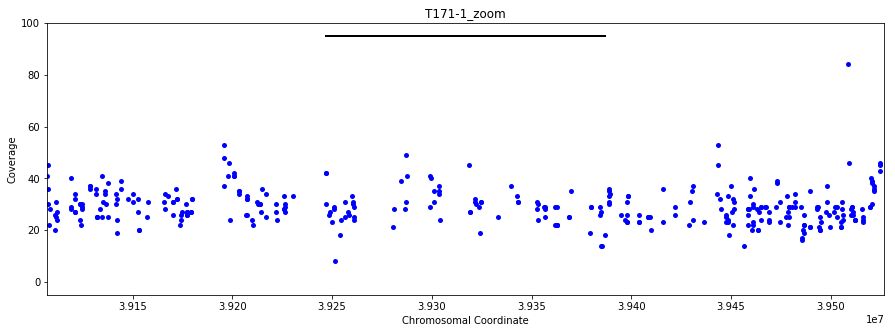

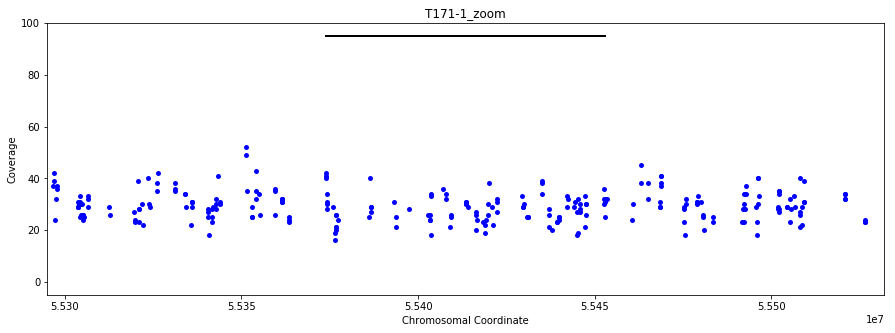

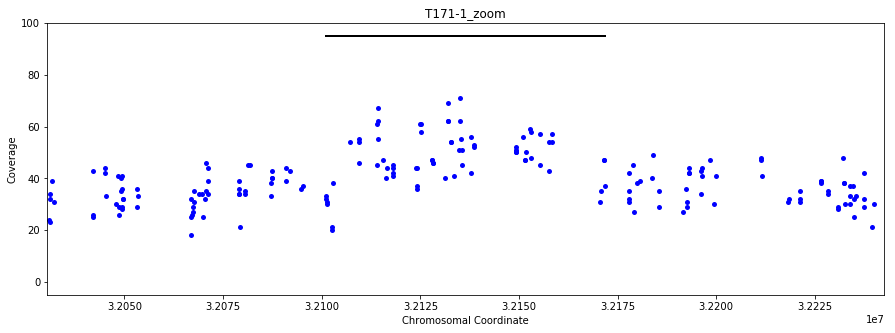

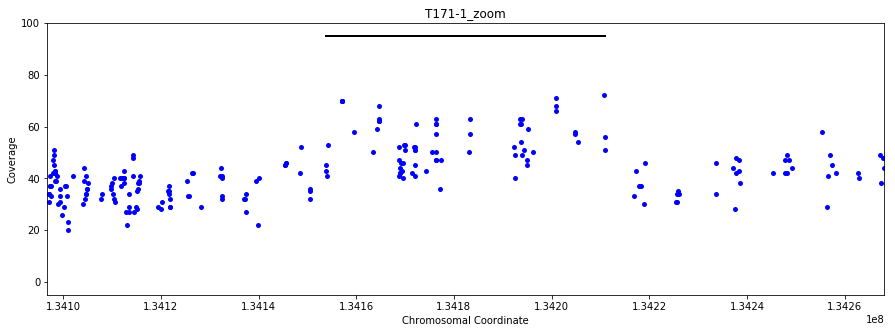

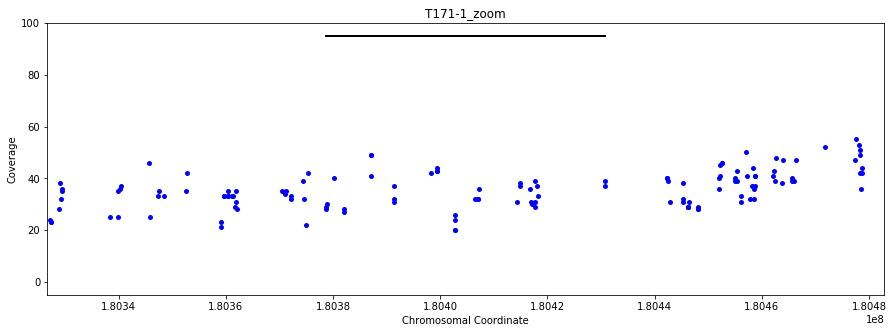

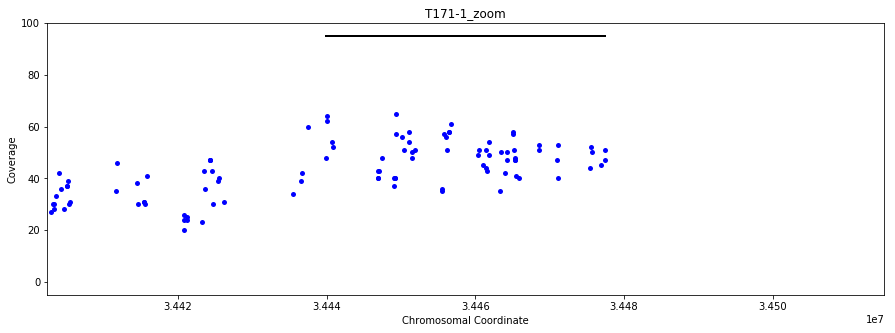

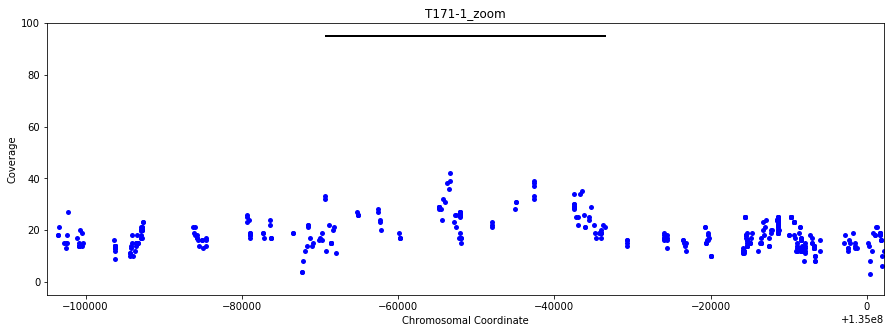

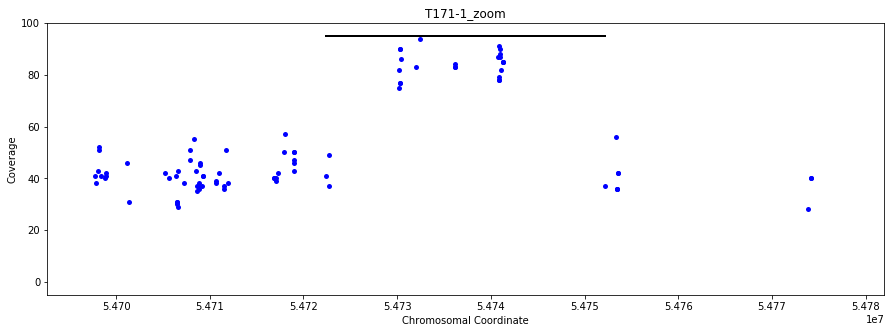

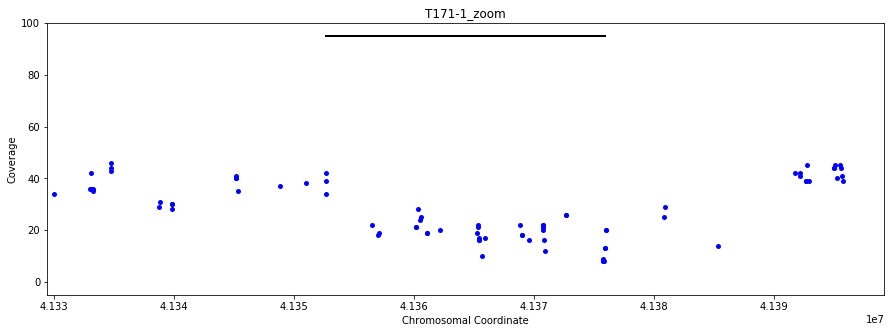

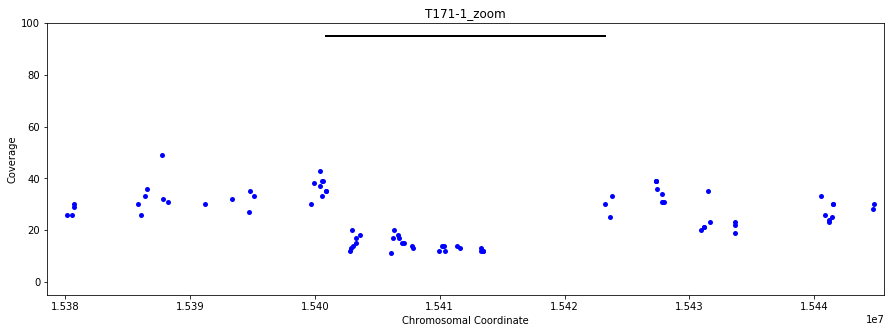

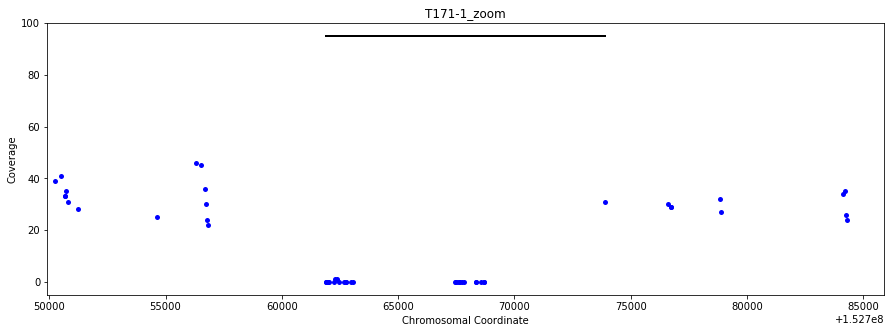

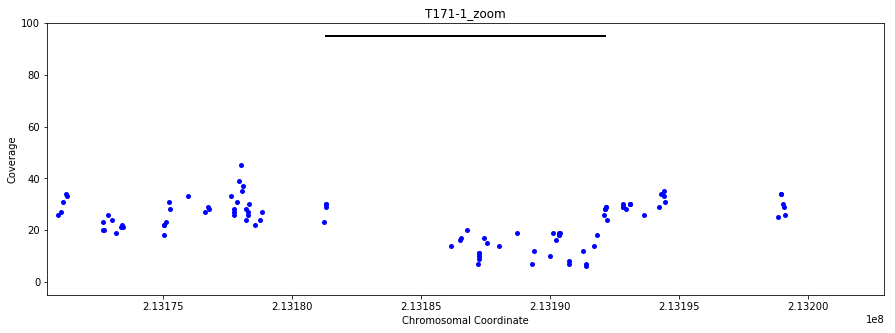

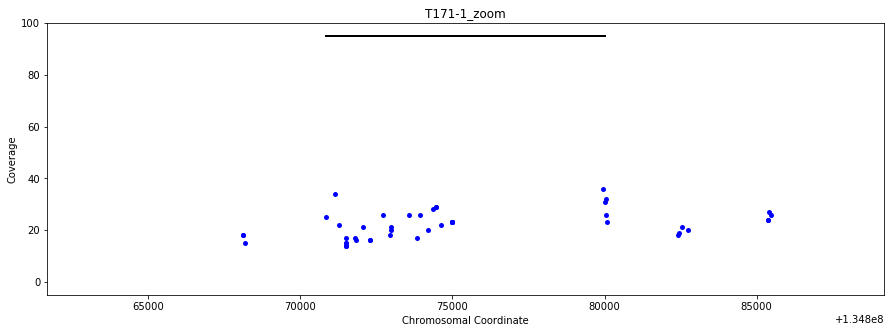

In [30]:
if __name__ == "__main__":
    Main()